<div >
<img src = "../banner.jpg" />
</div>

# Classification

In [1]:
#Cargar librerías 
require("pacman")
p_load(tidyverse)
set.seed(1011)

Loading required package: pacman



In [2]:
#Leer los datos 
credit <- readRDS(url("https://github.com/ignaciomsarmiento/datasets/blob/main/credit_class.rds?raw=true"))
head(credit)

,Default,duration,amount,installment,age,history,purpose,foreign,rent
,<int>,<int>,<int>,<int>,<int>,<fct>,<fct>,<fct>,<fct>
1,0,6,1169,4,67,terrible,goods/repair,foreign,FALSE
2,1,48,5951,2,22,poor,goods/repair,foreign,FALSE
3,0,12,2096,2,49,terrible,edu,foreign,FALSE
4,0,42,7882,2,45,poor,goods/repair,foreign,FALSE
5,1,24,4870,3,53,poor,newcar,foreign,FALSE
6,0,36,9055,2,35,poor,edu,foreign,FALSE


In [3]:
table(credit$foreign)


   <NA> foreign  german 
      0     963      37 

In [4]:
default<-credit$Default  #defino ahora va a servir después

#mutación de factores
credit<-credit %>% mutate(Default=factor(Default,levels=c(0,1),labels=c("No","Si")),
                          history=factor(history,levels=c("good","poor","terrible"),labels=c("buena","mala","terrible")),
                          foreign=factor(foreign,levels=c("foreign","german"),labels=c("extranjero","aleman")),
                          purpose=factor(purpose,levels=c("newcar","usedcar","goods/repair","edu", "biz" ),labels=c("auto_nuevo","auto_usado","bienes","educacion","negocios")))         

In [5]:
head(credit)

,Default,duration,amount,installment,age,history,purpose,foreign,rent
,<fct>,<int>,<int>,<int>,<int>,<fct>,<fct>,<fct>,<fct>
1,No,6,1169,4,67,terrible,bienes,extranjero,FALSE
2,Si,48,5951,2,22,mala,bienes,extranjero,FALSE
3,No,12,2096,2,49,terrible,educacion,extranjero,FALSE
4,No,42,7882,2,45,mala,bienes,extranjero,FALSE
5,Si,24,4870,3,53,mala,auto_nuevo,extranjero,FALSE
6,No,36,9055,2,35,mala,educacion,extranjero,FALSE


In [6]:
table(credit$foreign)


extranjero     aleman 
       963         37 

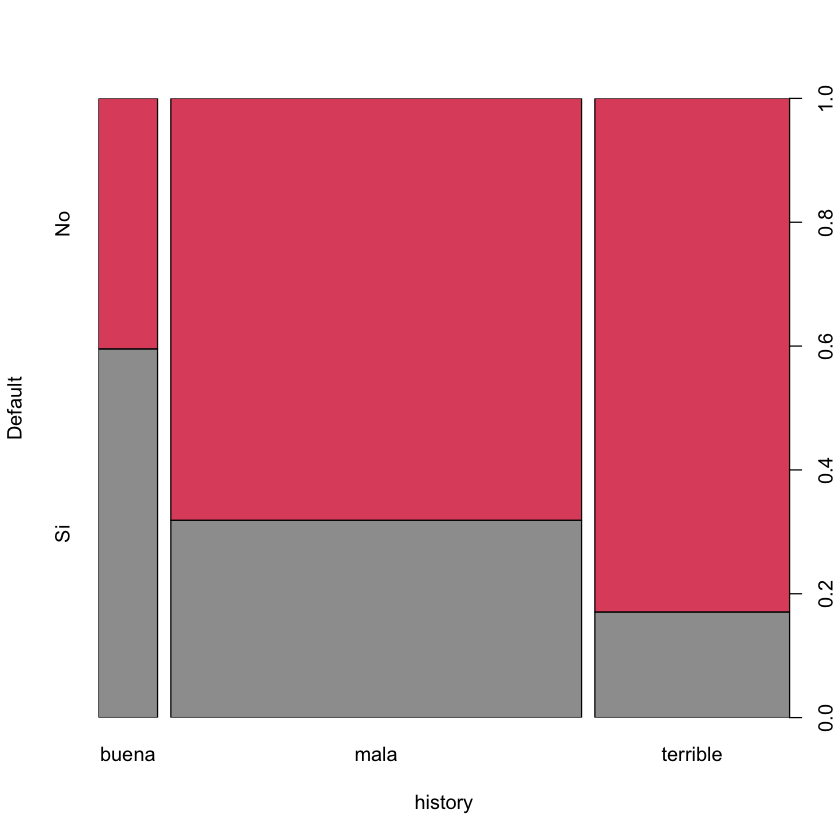

In [7]:
## plot a mosaic
plot(Default ~ history, data=credit, col=c(8,2), ylab="Default") ## surprise!
## the dangers of choice-based sampling!  

## Estimación Logit

\begin{align}
p_i &=\frac{e^{X_i\beta}}{1+e^{X_i\beta}}
\end{align}


In [8]:
mylogit <- glm(Default~., data = credit, family = "binomial")
summary(mylogit,type="text")


Call:
glm(formula = Default ~ ., family = "binomial", data = credit)

Coefficients:
                    Estimate Std. Error z value Pr(>|z|)    
(Intercept)       -1.936e-01  4.579e-01  -0.423  0.67239    
duration           2.666e-02  8.152e-03   3.270  0.00108 ** 
amount             9.793e-05  3.670e-05   2.668  0.00763 ** 
installment        2.361e-01  7.687e-02   3.072  0.00213 ** 
age               -1.598e-02  7.348e-03  -2.175  0.02964 *  
historymala       -1.101e+00  2.490e-01  -4.424 9.67e-06 ***
historyterrible   -1.849e+00  2.837e-01  -6.518 7.13e-11 ***
purposeauto_usado -1.702e+00  3.273e-01  -5.201 1.98e-07 ***
purposebienes     -7.551e-01  1.867e-01  -4.044 5.25e-05 ***
purposeeducacion  -1.473e-01  3.263e-01  -0.451  0.65166    
purposenegocios   -8.501e-01  2.801e-01  -3.036  0.00240 ** 
foreignaleman     -1.322e+00  5.814e-01  -2.274  0.02298 *  
rentTRUE           5.702e-01  1.944e-01   2.934  0.00335 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 

## Prediction


\begin{align}
\hat{p}_i &=\frac{e^{X_i\hat{\beta}}}{1+e^{X_i\hat{\beta}}}
\end{align}

In [10]:

credit<- credit  %>% mutate(prob_hat=predict(mylogit,newdata = credit, type = "response")) #type = "response" gives the predicted probabilities.

head(credit  %>% select(Default,prob_hat))


,Default,prob_hat
,<fct>,<dbl>
1,No,0.06602463
2,Si,0.48318910
3,No,0.12179580
4,No,0.39995570
5,Si,0.42139444
6,No,0.57856013


## Classification 

\begin{align}
\hat{Y}_i= 1[\hat{p}_i >0.5]
\end{align}

In [11]:
rule <- 1/2 # Bayes Rule

credit <-  credit  %>% mutate(Default_hat=ifelse(prob_hat>rule,1,0))    ## predicted class labels

head(credit  %>% select(Default,prob_hat,Default_hat))

,Default,prob_hat,Default_hat
,<fct>,<dbl>,<dbl>
1,No,0.06602463,0
2,Si,0.48318910,0
3,No,0.12179580,0
4,No,0.39995570,0
5,Si,0.42139444,0
6,No,0.57856013,1


## Aside: Dummy Vars

In [ ]:
p_load("caret")
dmy <- dummyVars(" ~ .", data = credit) # One-hot-encoding
head(dmy)

In [ ]:
credit <- data.frame(predict(dmy, newdata = credit))

In [ ]:
head(credit)

## Out of sample prediction

In [ ]:
credit<- credit  %>% mutate(Default=factor(Default.Si,levels=c(0,1),labels=c("No","Si")))

In [ ]:
inTrain <- createDataPartition(
  y = credit$Default.Si,## La variable dependiente u objetivo 
  p = .7, ## Usamos 70%  de los datos en el conjunto de entrenamiento 
  list = FALSE)


train <- credit[ inTrain,]
test  <- credit[-inTrain,]

In [ ]:
head(train)

### Logit

In [ ]:
fiveStats <- function(...) c(twoClassSummary(...), defaultSummary(...)) 



ctrl<- trainControl(method = "cv",
                    number = 5,
                    summaryFunction = fiveStats, 
                    classProbs = TRUE,
                    verbose=FALSE,
                    savePredictions = T)

set.seed(1410)
mylogit_caret <- train(Default.Si~duration+amount+installment+age+
                       history.buena+history.mala+history.terrible+
                       purpose.auto_nuevo+purpose.auto_usado+purpose.bienes+purpose.educacion+purpose.negocios+
                       foreign.extranjero+foreign.aleman+
                       rent.NA+rent.FALSE+rent.TRUE, 
                       data = train, 
                       method = "glm",
                       trControl = ctrl,
                       family = "binomial", 
                       metric = 'ROC')




mylogit_caret


In [ ]:
set.seed(1410)
mylogit_caret <- train(Default~duration+amount+installment+age+
                       history.buena+history.mala+history.terrible+
                       purpose.auto_nuevo+purpose.auto_usado+purpose.bienes+purpose.educacion+purpose.negocios+
                       foreign.extranjero+foreign.aleman+
                       rent.NA+rent.FALSE+rent.TRUE, 
                       data = train, 
                       method = "glm",
                       trControl = ctrl,
                       family = "binomial", 
                       metric = 'ROC')




mylogit_caret


In [ ]:
set.seed(1410)
mylogit_caret <- train(Default~duration+amount+installment+age+
                       history.buena+history.mala+
                       purpose.auto_nuevo+purpose.auto_usado+purpose.bienes+purpose.educacion+
                       foreign.extranjero+
                       +rent.TRUE, 
                       data = train, 
                       method = "glm",
                       trControl = ctrl,
                       family = "binomial", 
                       metric = 'ROC')


mylogit_caret

In [ ]:
predictTest_logit <- data.frame(
  obs = test$Default,                                    ## observed class labels
  predict(mylogit_caret, newdata = test, type = "prob"),         ## predicted class probabilities
  pred = predict(mylogit_caret, newdata = test, type = "raw")    ## predicted class labels
)


In [ ]:
head(predictTest_logit)